In [7]:
# -*- coding: utf-8 -*-
"""GNN Model.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1pSO-VEyn5Cywjw9sXKn2fjXdVbI3hAsH
"""

# -*- coding: utf-8 -*-
"""Untitled2.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/193StgLnr4doKklAxwBiQsVX3njEfb1oa
"""


DATA_PATH = r"C:\Users\hu4227mo-s\OneDrive - Lund University\updated_data (4).xlsx"

LA Downtown Weather Forecasting with Temporal Fusion Transformer
Filtered data to LA Downtown only
Loaded data with 39447 records
Found 32 records for Spring target day (4/15/2024)
Found 1 records for Summer target day (7/20/2024)
Found 1 records for Fall target day (10/10/2024)
Found 27 records for Winter target day (1/15/2024)
Using station: ['LA Downtown']
Created dataset with 69 valid windows
Training model on LA Downtown data...
Starting training for 30 epochs with patience 5...
Epoch 1/30
  Train Loss: 0.0437 (3 batches, avg batch time: 0.040s)
  Val Loss: 0.0131 (validation time: 0.31s)
  Epoch Time: 2.69s, Est. Remaining: 1.30 minutes
  Elapsed Time: 0.04 minutes
  Saved best model with val loss: 0.0131
Epoch 2/30
  Train Loss: 0.0191 (3 batches, avg batch time: 0.087s)
  Val Loss: 0.0161 (validation time: 0.59s)
  Epoch Time: 2.86s, Est. Remaining: 1.29 minutes
  Elapsed Time: 0.09 minutes
  No improvement for 1/5 epochs
Epoch 3/30
  Train Loss: 0.0181 (3 batches, avg batch ti

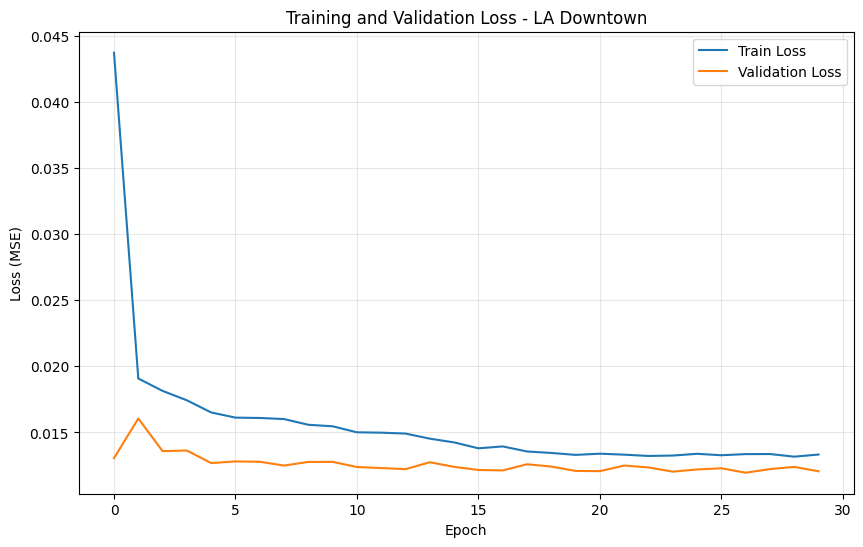

Evaluating model on LA Downtown...
Debug - Output shape: (1, 1, 24), Target shape: (1, 1, 24)
Overall Metrics - RMSE: 0.1191, MAE: 0.1015, R²: -0.0290
Station LA Downtown (urban) - RMSE: 0.1191, MAE: 0.1015, R²: -0.0290
Error processing visualization data: 'list' object has no attribute 'to'

Creating and visualizing seasonal datasets...
Creating dataset for Spring: 2024-04-15
Created Spring dataset with shapes: X_temporal=torch.Size([1, 7, 1, 24]), X_static=torch.Size([1, 1, 2]), y=torch.Size([1, 1, 24])
Creating dataset for Summer: 2024-07-20
Created Summer dataset with shapes: X_temporal=torch.Size([1, 7, 1, 24]), X_static=torch.Size([1, 1, 2]), y=torch.Size([1, 1, 24])
Creating dataset for Fall: 2024-10-10
Created Fall dataset with shapes: X_temporal=torch.Size([1, 7, 1, 24]), X_static=torch.Size([1, 1, 2]), y=torch.Size([1, 1, 24])
Creating dataset for Winter: 2024-01-15
Created Winter dataset with shapes: X_temporal=torch.Size([1, 7, 1, 24]), X_static=torch.Size([1, 1, 2]), y=tor

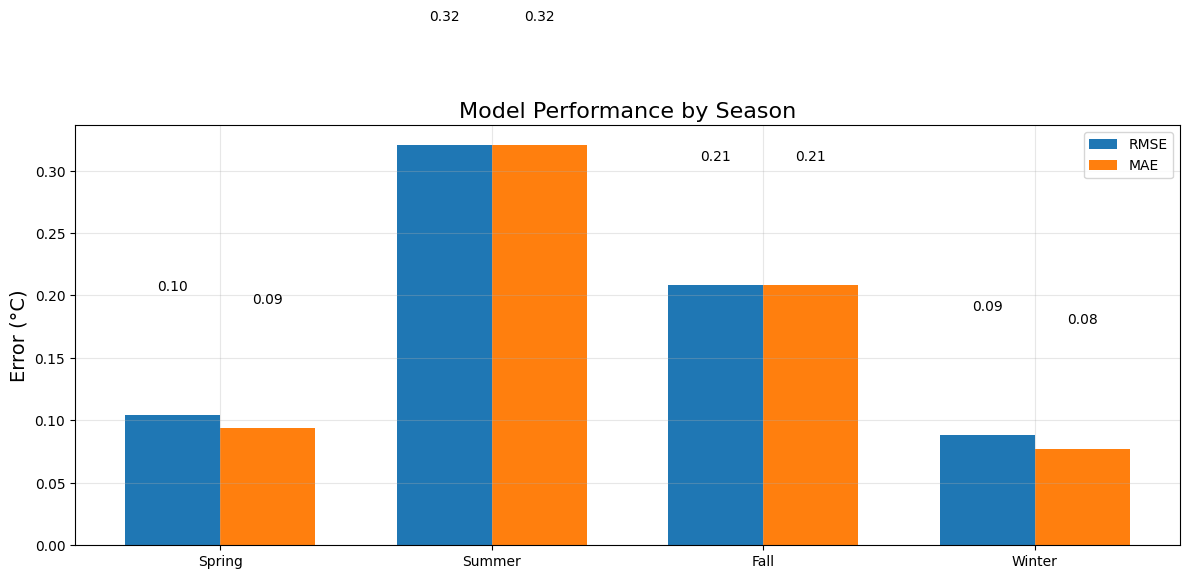


Creating seasonal datasets...
Creating dataset for Spring: 2024-04-15
Created Spring dataset with shapes: X_temporal=torch.Size([1, 7, 1, 24]), X_static=torch.Size([1, 1, 2]), y=torch.Size([1, 1, 24])
Creating dataset for Summer: 2024-07-20
Created Summer dataset with shapes: X_temporal=torch.Size([1, 7, 1, 24]), X_static=torch.Size([1, 1, 2]), y=torch.Size([1, 1, 24])
Creating dataset for Fall: 2024-10-10
Created Fall dataset with shapes: X_temporal=torch.Size([1, 7, 1, 24]), X_static=torch.Size([1, 1, 2]), y=torch.Size([1, 1, 24])
Creating dataset for Winter: 2024-01-15
Created Winter dataset with shapes: X_temporal=torch.Size([1, 7, 1, 24]), X_static=torch.Size([1, 1, 2]), y=torch.Size([1, 1, 24])

Creating seasonal datasets...
Creating dataset for Spring: 2024-04-15
Created Spring dataset with shapes: X_temporal=torch.Size([1, 7, 1, 24]), X_static=torch.Size([1, 1, 2]), y=torch.Size([1, 1, 24])
Creating dataset for Summer: 2024-07-20
Created Summer dataset with shapes: X_temporal=

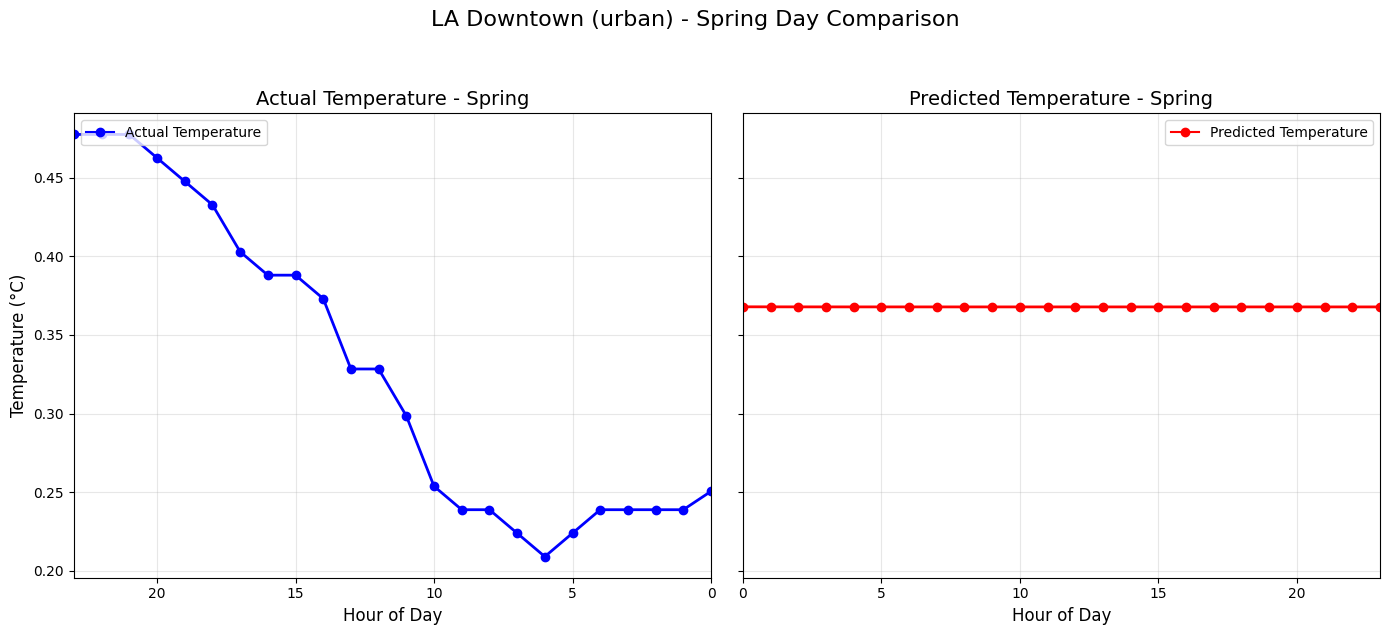

Processing Summer forecast...
Summer - RMSE: 0.3202, MAE: 0.3202, R²: 0.0000


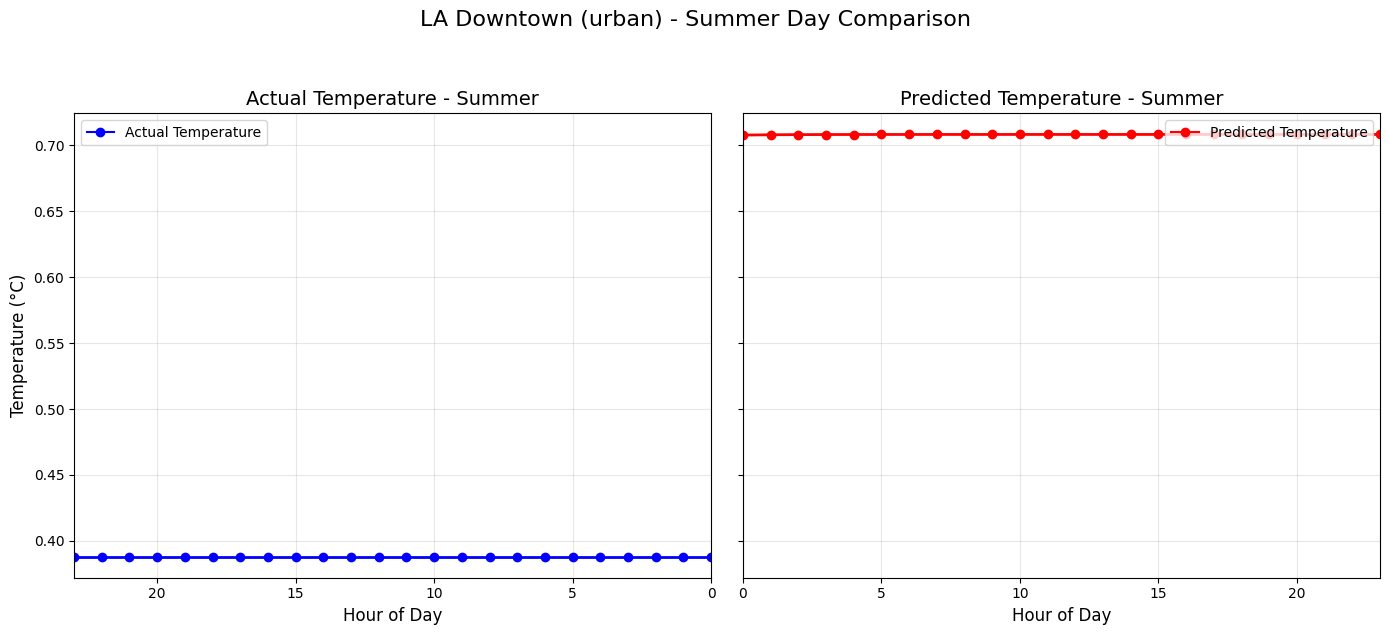

Processing Fall forecast...
Fall - RMSE: 0.2081, MAE: 0.2081, R²: 0.0000


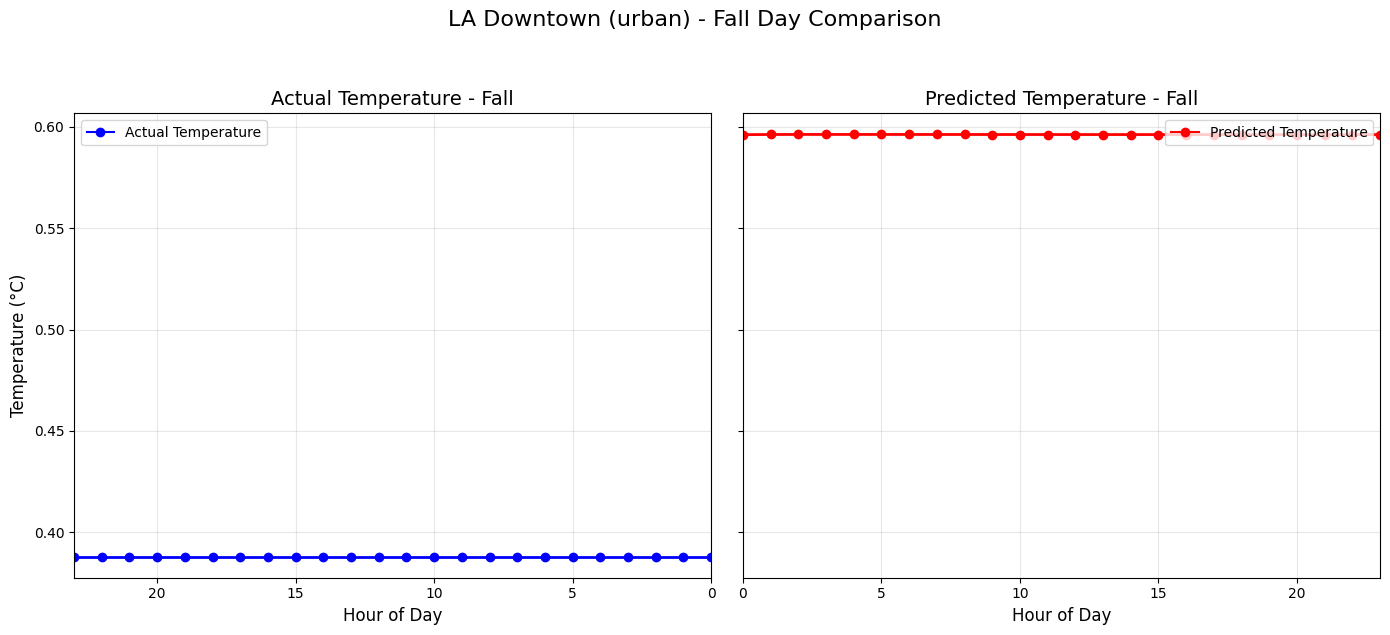

Processing Winter forecast...
Winter - RMSE: 0.0880, MAE: 0.0774, R²: -0.1348


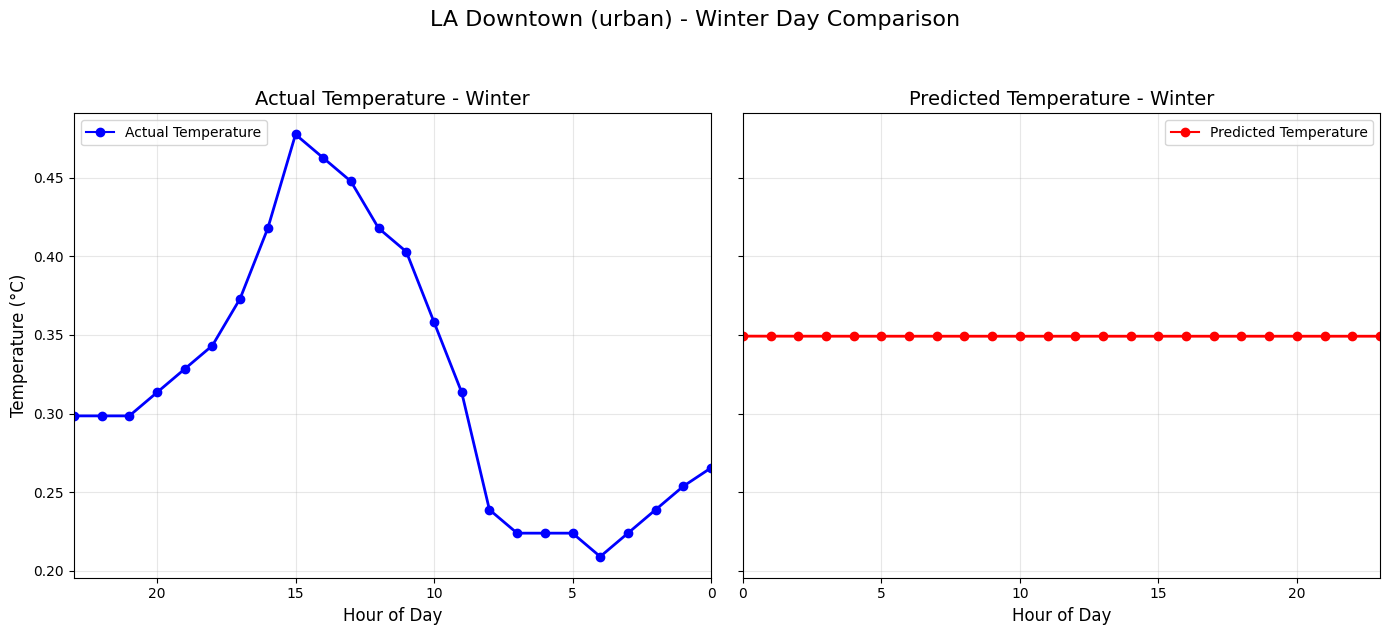

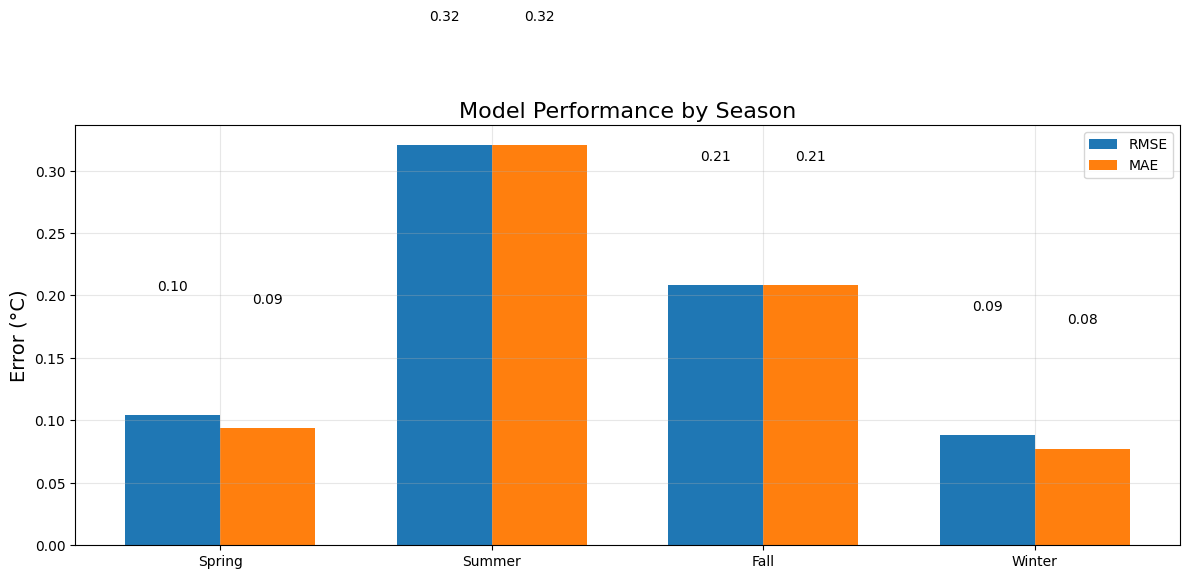

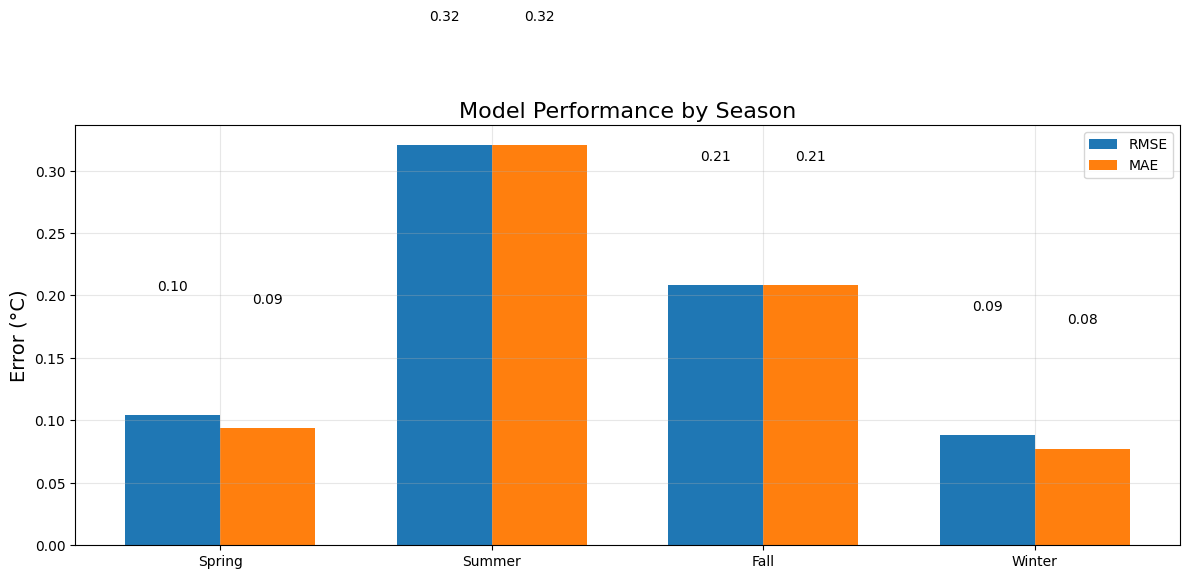

Skipping topographic analysis since we only have data for LA Downtown
Results saved to la_downtown_results.csv


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cpu')  # Using CPU as specified

# ============================================================
# MODIFIED DATA LOADING AND PROCESSING FOR TARGETED SEASONAL ANALYSIS
# ============================================================

def load_data(file_path):
    """
    Load weather data, clean missing values, and filter to LA Downtown only.
    """
    try:
        # Determine file type and read
        if file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path, engine='openpyxl')
        else:
            df = pd.read_csv(file_path, encoding='ISO-8859-1')
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()  # Return empty DataFrame

    # Convert timestamp
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    elif 'DATE' in df.columns:
        df['timestamp'] = pd.to_datetime(df['DATE'])
        df = df.rename(columns={'DATE': 'date_original'})

    # Ensure time-based ordering before interpolation
    df = df.sort_values(by='timestamp')

    # Add hour of day feature - sine/cosine encoding for cyclical pattern
    df['hour_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.hour / 24)

    # Add day of year feature - sine/cosine encoding for cyclical pattern
    df['day_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.dayofyear / 365.25)
    df['day_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.dayofyear / 365.25)

    # Define region mapping for LA Downtown only
    region_mapping = {
        'LA Downtown': 'urban'
    }

    # Filter to keep only LA Downtown
    if 'station_id' in df.columns:
        # Filter to LA Downtown only
        df = df[df['station_id'] == 'LA Downtown']
        
        # Add region information
        df['region'] = df['station_id'].map(region_mapping)

        # Convert region to numerical encoding
        region_to_num = {region: i for i, region in enumerate(df['region'].unique())}
        df['region_code'] = df['region'].map(region_to_num)

        # Add elevation for LA Downtown
        elevation_mapping = {
            'LA Downtown': 93         # meters
        }
        df['elevation'] = df['station_id'].map(elevation_mapping)
        # Normalize elevation (will be constant for single station)
        df['elevation_norm'] = 0.0  # Since we only have one station, just use 0 as normalized value

        print(f"Filtered data to LA Downtown only")

    # Interpolate missing values along the time dimension
    df.interpolate(method='linear', limit_direction='both', inplace=True)

    return df


def extract_target_days(df):
    """
    Extract the 4 specific target days (one per season) for predictions
    """
    # Define target days
    target_days = [
        {'season': 'Spring', 'month': 4, 'day': 15},  # April 15
        {'season': 'Summer', 'month': 7, 'day': 20},  # July 20
        {'season': 'Fall', 'month': 10, 'day': 10},   # October 10
        {'season': 'Winter', 'month': 1, 'day': 15}   # January 15
    ]

    # Filter for each target day
    target_data = {}
    for target in target_days:
        # Filter by month and day
        day_data = df[(df['timestamp'].dt.month == target['month']) &
                       (df['timestamp'].dt.day == target['day'])]

        # Get the most recent year that has data for this day
        if not day_data.empty:
            latest_year = day_data['timestamp'].dt.year.max()
            target_day_data = day_data[day_data['timestamp'].dt.year == latest_year]
            target_data[target['season']] = target_day_data
            print(f"Found {len(target_day_data)} records for {target['season']} target day ({target['month']}/{target['day']}/{latest_year})")
        else:
            print(f"WARNING: No data found for {target['season']} target day")

    return target_data

def prepare_seasonal_training_data(df, target_days):
    """
    For each target day, prepare all historical data for training
    """
    training_sets = {}

    for season, target_day_data in target_days.items():
        if target_day_data.empty:
            continue

        # Get the date of this target
        sample_date = target_day_data['timestamp'].iloc[0]
        target_year = sample_date.year

        # Use all historical data prior to the target year
        historical_data = df[df['timestamp'].dt.year < target_year]

        training_sets[season] = historical_data
        print(f"{season} training set: {len(historical_data)} samples from all historical data")

    return training_sets

def normalize_features(train_df, val_df, feature_cols):
    """
    Normalize features using StandardScaler fitted on training data
    """
    scaler = StandardScaler()

    # Fit on training data
    scaler.fit(train_df[feature_cols])

    # Transform datasets
    train_scaled = scaler.transform(train_df[feature_cols])
    val_scaled = scaler.transform(val_df[feature_cols])

    # Convert back to DataFrames
    train_norm = pd.DataFrame(train_scaled, columns=feature_cols, index=train_df.index)
    val_norm = pd.DataFrame(val_scaled, columns=feature_cols, index=val_df.index)

    return train_norm, val_norm, scaler

class WeatherDataset(Dataset):
    """
    Dataset for weather forecasting with sliding window approach.
    Modified to work efficiently with single station (LA Downtown).
    """
    def __init__(self, df, station_ids, feature_cols, seq_length=24, forecast_horizon=24):
        """
        Args:
            df: DataFrame with weather data (filtered to LA Downtown only)
            station_ids: List containing only 'LA Downtown'
            feature_cols: List of feature columns to use as input
            seq_length: Length of input sequence (in hours)
            forecast_horizon: How many hours ahead to predict
        """
        self.df = df
        self.station_ids = station_ids
        self.feature_cols = feature_cols
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon
        self.n_stations = len(station_ids)  # Should be 1

        # Get unique timestamps (now all from one station)
        self.timestamps = sorted(df['timestamp'].unique())

        # Filter valid timestamps (those that have enough history and future data)
        valid_idx = []
        for i in range(len(self.timestamps) - (seq_length + forecast_horizon - 1)):
            # Check if we have continuous data for this window
            current_time = self.timestamps[i]
            end_time = self.timestamps[i + seq_length + forecast_horizon - 1]
            expected_duration = timedelta(hours=seq_length + forecast_horizon - 1)

            if (end_time - current_time) == expected_duration:
                valid_idx.append(i)

        self.valid_indices = valid_idx

        # Add a safety check to ensure we have at least one valid window
        if len(self.valid_indices) == 0:
            print(f"WARNING: No valid windows found in dataset. Using reduced requirements.")
            # Fall back to allowing any windows where we have both input and output data
            valid_idx = []
            for i in range(len(self.timestamps) - seq_length):
                if i + seq_length < len(self.timestamps):
                    valid_idx.append(i)
            self.valid_indices = valid_idx
            self.fallback_mode = True
            print(f"Found {len(self.valid_indices)} windows with relaxed continuity requirements")
        else:
            self.fallback_mode = False
            print(f"Created dataset with {len(self.valid_indices)} valid windows")

    def __len__(self):
        return max(1, len(self.valid_indices))  # Ensure length is at least 1

    def __getitem__(self, idx):
        if len(self.valid_indices) == 0:
            # Return dummy data if no valid indices
            X = np.zeros((len(self.feature_cols), self.n_stations, self.seq_length))
            y = np.zeros((self.n_stations, self.forecast_horizon))
            static_features = np.zeros((self.n_stations, 2))  # region_code and elevation
            return (torch.FloatTensor(X), torch.FloatTensor(static_features)), torch.FloatTensor(y)

        # Get actual data when possible
        start_idx = self.valid_indices[idx % len(self.valid_indices)]

        # Get timestamps for input and output windows
        input_timestamps = self.timestamps[start_idx:start_idx + self.seq_length]
        output_timestamps = self.timestamps[start_idx + self.seq_length:
                                            start_idx + self.seq_length + self.forecast_horizon]

        # Handle potential shortfall in output window (fallback mode)
        if self.fallback_mode and len(output_timestamps) < self.forecast_horizon:
            # Pad with repetition of last timestamp if needed
            last_time = output_timestamps[-1] if len(output_timestamps) > 0 else input_timestamps[-1]
            padding = [last_time] * (self.forecast_horizon - len(output_timestamps))
            output_timestamps = list(output_timestamps) + padding

        # Initialize tensors - simpler now with just one station
        X = np.zeros((len(self.feature_cols), 1, self.seq_length))  # Only one station
        y = np.zeros((1, self.forecast_horizon))  # Only one station
        static_features = np.zeros((1, 2))  # region_code and elevation

        # LA Downtown is our only station
        station_id = 'LA Downtown'
        
        # Input sequence
        for t_idx, ts in enumerate(input_timestamps):
            station_data = self.df[self.df['timestamp'] == ts]

            if not station_data.empty:
                for f_idx, feat in enumerate(self.feature_cols):
                    X[f_idx, 0, t_idx] = station_data[feat].values[0]

                # Store static features (same for all timestamps)
                if t_idx == 0:
                    static_features[0, 0] = station_data['region_code'].values[0]
                    static_features[0, 1] = station_data['elevation_norm'].values[0]

        # Target sequence (temperature only)
        for t_idx, ts in enumerate(output_timestamps):
            if t_idx < self.forecast_horizon:  # Safety check
                station_data = self.df[self.df['timestamp'] == ts]

                if not station_data.empty:
                    y[0, t_idx] = station_data['Temperature_C'].values[0]

        return (torch.FloatTensor(X), torch.FloatTensor(static_features)), torch.FloatTensor(y)
# ============================================================
# TEMPORAL FUSION TRANSFORMER IMPLEMENTATION
# ============================================================
class TemporalSelfAttention(nn.Module):
    """
    Multi-head self-attention layer for temporal data.
    Simplified from the original TFT paper.
    """
    def __init__(self, d_model, n_heads=2, dropout=0.1):
        super(TemporalSelfAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        # Linear projections
        queries = self.query(x).view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)
        keys = self.key(x).view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)
        values = self.value(x).view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / np.sqrt(self.head_dim)
        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)

        # Apply attention to values
        out = torch.matmul(attention, values)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

        # Final linear layer
        return self.out(out)

class GatedResidualNetwork(nn.Module):
    """
    Gated Residual Network as described in the TFT paper.
    Simplified version with fewer layers.
    """
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super(GatedResidualNetwork, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        # If input and output sizes are different, apply a skip connection
        self.skip_layer = None
        if input_size != output_size:
            self.skip_layer = nn.Linear(input_size, output_size)

        # Main layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.gate = nn.Linear(input_size + output_size, output_size)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(output_size)

    def forward(self, x):
        # Main branch
        hidden = F.elu(self.fc1(x))
        hidden = self.dropout(hidden)
        hidden = self.fc2(hidden)

        # Skip connection
        if self.skip_layer is not None:
            skip = self.skip_layer(x)
        else:
            skip = x

        # Gate mechanism
        gate_input = torch.cat([x, hidden], dim=-1)
        gate = torch.sigmoid(self.gate(gate_input))

        # Combine using gate
        output = gate * hidden + (1 - gate) * skip

        # Layer normalization
        return self.layer_norm(output)

class VariableSelectionNetwork(nn.Module):
    """
    Variable Selection Network for TFT.
    Simplified version with fewer layers.
    """
    def __init__(self, input_size_per_var, num_vars, hidden_size, output_size, dropout=0.1):
        super(VariableSelectionNetwork, self).__init__()
        self.input_size_per_var = input_size_per_var
        self.num_vars = num_vars
        self.hidden_size = hidden_size
        self.output_size = output_size

        # GRN for variable weights
        self.weight_grn = GatedResidualNetwork(
            input_size=input_size_per_var * num_vars,
            hidden_size=hidden_size,
            output_size=num_vars,
            dropout=dropout
        )

        # GRN for each variable
        self.var_grns = nn.ModuleList([
            GatedResidualNetwork(
                input_size=input_size_per_var,
                hidden_size=hidden_size,
                output_size=output_size,
                dropout=dropout
            ) for _ in range(num_vars)
        ])

    def forward(self, x):
        # x shape: [batch_size, num_vars, input_size_per_var]
        batch_size = x.size(0)
        flat_x = x.view(batch_size, -1)

        # Calculate variable weights
        var_weights = self.weight_grn(flat_x)
        var_weights = F.softmax(var_weights, dim=-1).unsqueeze(-1)  # [batch_size, num_vars, 1]

        # Transform each variable
        var_outputs = []
        for i in range(self.num_vars):
            var_outputs.append(self.var_grns[i](x[:, i]))

        var_outputs = torch.stack(var_outputs, dim=1)  # [batch_size, num_vars, output_size]

        # Weighted combination
        outputs = torch.sum(var_outputs * var_weights, dim=1)  # [batch_size, output_size]

        return outputs, var_weights

class TemporalFusionTransformer(nn.Module):
    """
    Simplified Temporal Fusion Transformer for temperature forecasting.
    """
    def __init__(self, num_features, num_stations, hidden_size=64, num_heads=2, dropout=0.1, forecast_horizon=24):
        super(TemporalFusionTransformer, self).__init__()
        self.num_features = num_features
        self.num_stations = num_stations
        self.hidden_size = hidden_size
        self.forecast_horizon = forecast_horizon  # Store forecast horizon

        # Static variable processing (region_code, elevation)
        self.static_var_processor = GatedResidualNetwork(
            input_size=2,
            hidden_size=hidden_size,
            output_size=hidden_size,
            dropout=dropout
        )

        # Variable selection for time-varying features
        self.temporal_var_selection = VariableSelectionNetwork(
            input_size_per_var=24,  # Sequence length per feature
            num_vars=num_features,
            hidden_size=hidden_size,
            output_size=hidden_size,
            dropout=dropout
        )

        # LSTM encoder
        self.lstm_encoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True
        )

        # Temporal self-attention
        self.self_attention = TemporalSelfAttention(
            d_model=hidden_size,
            n_heads=num_heads,
            dropout=dropout
        )

        # Final output layers
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, forecast_horizon)  # 24-hour forecast

    def forward(self, inputs):
        # Unpack inputs
        temporal_features, static_features = inputs
        batch_size = temporal_features.size(0)

        # [batch, features, stations, time] -> [batch*stations, features, time]
        temporal_features = temporal_features.permute(0, 2, 1, 3)
        temporal_features = temporal_features.reshape(batch_size * self.num_stations, self.num_features, -1)

        # Static features: [batch, stations, static_dims] -> [batch*stations, static_dims]
        static_features = static_features.reshape(batch_size * self.num_stations, -1)

        # Process static features
        static_embeddings = self.static_var_processor(static_features)

        # Process temporal features with variable selection
        temporal_embeddings, temporal_weights = self.temporal_var_selection(temporal_features)

        # Reshape to [batch*stations, seq_len, hidden]
        temporal_embeddings = temporal_embeddings.unsqueeze(1).expand(-1, 24, -1)

        # Add static embeddings to each timestep
        temporal_embeddings = temporal_embeddings + static_embeddings.unsqueeze(1)

        # LSTM encoding
        lstm_out, _ = self.lstm_encoder(temporal_embeddings)

        # Self-attention
        attention_out = self.self_attention(lstm_out)

        # Final prediction
        outputs = F.relu(self.fc1(attention_out))
        outputs = self.fc2(outputs)

        # Take the last 24 timesteps for the forecast
        forecast = outputs[:, -24:, 0]

        # Reshape back to [batch, stations, horizon]
        forecast = forecast.reshape(batch_size, self.num_stations, -1)

        return forecast

# ============================================================
# TRAINING AND EVALUATION FUNCTIONS
# ============================================================
def train_model(model, train_loader, val_loader, learning_rate=0.001, epochs=30, patience=5):
    """
    Train the model with early stopping based on validation loss.
    """
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    epoch_times = []

    print(f"Starting training for {epochs} epochs with patience {patience}...")
    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()
        # Training
        model.train()
        train_loss = 0
        train_batches = 0

        batch_times = []
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            batch_start = time.time()
            
            # Move to device - handle ALL possible input types
            if isinstance(inputs, tuple):
                inputs = tuple(x.to(device) for x in inputs)
            elif isinstance(inputs, list):
                inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs]
            else:
                inputs = inputs.to(device)

            targets = targets.to(device)

            

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1
            
            batch_end = time.time()
            batch_time = batch_end - batch_start
            batch_times.append(batch_time)
            
            # Print progress every 10 batches
            if (batch_idx + 1) % 10 == 0:
                print(f"  Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}, Time: {batch_time:.3f}s")

        avg_train_loss = train_loss / max(1, train_batches)
        train_losses.append(avg_train_loss)
        
        avg_batch_time = sum(batch_times) / len(batch_times) if batch_times else 0
        
       # Validation
        val_start_time = time.time()
        model.eval()
        val_loss = 0
        val_batches = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                # Move to device - handle ALL possible input types
                if isinstance(inputs, tuple):
                    inputs = tuple(x.to(device) for x in inputs)
                elif isinstance(inputs, list):
                    inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs]
                else:
                    inputs = inputs.to(device)
                    
                targets = targets.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / max(1, val_batches)
        val_losses.append(avg_val_loss)
        
        val_time = time.time() - val_start_time
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_time)
        
        # Calculate estimated time remaining
        avg_epoch_time = sum(epoch_times) / len(epoch_times)
        remaining_epochs = epochs - (epoch + 1)
        est_time_remaining = avg_epoch_time * remaining_epochs
        
        # Print detailed progress
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f} ({train_batches} batches, avg batch time: {avg_batch_time:.3f}s)")
        print(f"  Val Loss: {avg_val_loss:.4f} (validation time: {val_time:.2f}s)")
        print(f"  Epoch Time: {epoch_time:.2f}s, Est. Remaining: {est_time_remaining/60:.2f} minutes")
        print(f"  Elapsed Time: {(epoch_end_time - total_start_time)/60:.2f} minutes")

        # Learning rate scheduler
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            try:
                torch.save(model.state_dict(), 'best_tft_model.pth')
                print(f"  Saved best model with val loss: {best_val_loss:.4f}")
            except Exception as e:
                print(f"  Error saving model: {e}")
        else:
            patience_counter += 1
            print(f"  No improvement for {patience_counter}/{patience} epochs")
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    total_time = time.time() - total_start_time
    print(f"Training completed in {total_time/60:.2f} minutes ({total_time:.1f} seconds)")
    print(f"Average epoch time: {sum(epoch_times)/len(epoch_times):.2f} seconds")

    # Load best model
    try:
        model.load_state_dict(torch.load('best_tft_model.pth'))
    except Exception as e:
        print(f"Error loading best model: {e}")

    return model, train_losses, val_losses

def evaluate_model(model, data_loader, station_ids, regions):
    """
    Evaluate the model and calculate metrics with robust dimension handling.
    """
    model.eval()
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            # Move to device - handle ALL possible input types
            if isinstance(inputs, tuple):
                inputs = tuple(x.to(device) for x in inputs)
            elif isinstance(inputs, list):
                inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs]
            else:
                inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)

            # Move to CPU for further processing
            outputs = outputs.cpu().numpy()
            targets = targets.numpy()
            
            # Store raw arrays for later processing
            all_outputs.append(outputs)
            all_targets.append(targets)

    # Process all collected outputs and targets
    # First, check dimensions of the first item to understand the structure
    sample_output = all_outputs[0]
    sample_target = all_targets[0]
    
    print(f"Debug - Output shape: {sample_output.shape}, Target shape: {sample_target.shape}")
    
    # Flatten everything to 1D arrays for simple metrics calculation
    flattened_outputs = np.concatenate([o.flatten() for o in all_outputs])
    flattened_targets = np.concatenate([t.flatten() for t in all_targets])
    
    # Calculate overall metrics
    rmse = np.sqrt(mean_squared_error(flattened_targets, flattened_outputs))
    mae = mean_absolute_error(flattened_targets, flattened_outputs)
    r2 = r2_score(flattened_targets, flattened_outputs)

    print(f"Overall Metrics - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    # Since we only have one station (LA Downtown), simplify the station metrics
    station_metrics = {
        station_ids[0]: {
            'region': regions.get(station_ids[0], 'Unknown'),
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }
    }
    
    print(f"Station {station_ids[0]} ({regions.get(station_ids[0], 'Unknown')}) - "
          f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    return rmse, mae, r2, station_metrics

def visualize_predictions(model, data_loader, station_ids, regions, season):
    """
    Visualize predictions for each station.
    """
    model.eval()
    if len(data_loader) == 0:
        print("No data available for visualization")
        return
    
    # Get predictions
    try:
        for inputs, targets in data_loader:
            # Only process one batch for visualization
            if isinstance(inputs, tuple):
                inputs = tuple(x.to(device) for x in inputs)
            else:
                inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)

            # Move to CPU for plotting
            outputs = outputs.cpu().numpy()
            targets = targets.numpy()
            break

        # Check if we have data to plot
        if 'outputs' not in locals():
            print("No data was loaded from the dataloader")
            return
    except Exception as e:
        print(f"Error processing visualization data: {e}")
        return
    
    # Create subplots for each station
    fig, axes = plt.subplots(len(station_ids), 1, figsize=(12, 3*len(station_ids)))
    if len(station_ids) == 1:
        axes = [axes]

    hours = np.arange(24)

    for i, station in enumerate(station_ids):
        ax = axes[i]

        # Plot actual vs predicted
        ax.plot(hours, targets[0, i, :], 'b-', label='Actual')
        ax.plot(hours, outputs[0, i, :], 'r--', label='Predicted')

        ax.set_title(f"{station} ({regions.get(station, 'Unknown')}) - {season}")
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{season}_predictions.png")
    plt.show()  # Add this line to display the plot
    plt.close()

def create_mirror_plot(model, data_loader, station_ids, regions, season):
    """
    Create a mirror plot with actual temperature on left side and predicted on right side.
    """
    model.eval()
    if len(data_loader) == 0:
        print(f"No data available for {season} mirror plot")
        return
    
    # Get predictions
    try:
        for inputs, targets in data_loader:
            # Move inputs to device - handle ALL possible input types
            if isinstance(inputs, tuple):
                inputs = tuple(x.to(device) for x in inputs)
            elif isinstance(inputs, list):
                inputs = [x.to(device) if isinstance(x, torch.Tensor) else x for x in inputs]
            else:
                inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)

            # Move to CPU for plotting
            outputs = outputs.cpu().numpy()
            targets = targets.numpy()
            break
            
        if 'outputs' not in locals():
            print(f"No data was loaded for {season} mirror plot")
            return
    except Exception as e:
        print(f"Error processing mirror plot data for {season}: {e}")
        import traceback
        traceback.print_exc()  # Print full error details
        return
    
    # Create a figure for each station
    for i, station in enumerate(station_ids):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
        
        hours = np.arange(24)
        
        # Left plot - Actual temperatures
        ax1.plot(hours, targets[0, i, :], 'b-o', linewidth=2)
        ax1.set_title(f"Actual Temperature - {season}", fontsize=14)
        ax1.set_xlabel('Hour of Day', fontsize=12)
        ax1.set_ylabel('Temperature (°C)', fontsize=12)
        ax1.set_xlim(0, 23)
        ax1.grid(True, alpha=0.3)
        ax1.invert_xaxis()  # Invert x-axis for mirror effect
        
        # Right plot - Predicted temperatures
        ax2.plot(hours, outputs[0, i, :], 'r-o', linewidth=2)
        ax2.set_title(f"Predicted Temperature - {season}", fontsize=14)
        ax2.set_xlabel('Hour of Day', fontsize=12)
        ax2.set_xlim(0, 23)
        ax2.grid(True, alpha=0.3)
        
        # Add overall title
        plt.suptitle(f"{station} ({regions.get(station, 'Unknown')}) - {season} Day Comparison", 
                    fontsize=16, y=1.05)
        
        # Add a line in the middle
        fig.tight_layout()
        plt.subplots_adjust(wspace=0.05)  # Reduce space between subplots
        
        # Save and display
        plt.savefig(f"{season}_mirror_comparison.png", bbox_inches='tight')
        plt.show()
        plt.close()

def create_seasonal_datasets(df, target_days, all_stations, feature_cols):
    """
    Create datasets for each seasonal day and visualize predictions.
    """
    seasonal_datasets = {}
    
    for season, day_data in target_days.items():
        if day_data.empty:
            print(f"No data available for {season}")
            continue
            
        # Get the date of this target day
        sample_date = day_data['timestamp'].iloc[0]
        print(f"Creating dataset for {season}: {sample_date.strftime('%Y-%m-%d')}")
        
        try:
            # Prepare the data in the format expected by the model
            # Format should be: temporal_features [batch, features, stations, time], static_features [batch, stations, static_features]
            
            # Reshape features to match expected format
            temporal_data = np.zeros((1, len(feature_cols), 1, 24))  # [batch=1, features, stations=1, time=24]
            
            # Fill in the temporal features
            for f_idx, feat in enumerate(feature_cols):
                if feat in day_data.columns:
                    temporal_data[0, f_idx, 0, :] = day_data[feat].values[:24]  # Using first 24 records
            
            # Create static features (region_code and elevation)
            static_data = np.zeros((1, 1, 2))  # [batch=1, stations=1, static_features=2]
            static_data[0, 0, 0] = day_data['region_code'].iloc[0] 
            static_data[0, 0, 1] = day_data['elevation_norm'].iloc[0]
            
            # Create target (actual temperatures)
            target_data = np.zeros((1, 1, 24))  # [batch=1, stations=1, time=24]
            target_data[0, 0, :] = day_data['Temperature_C'].values[:24]  # Using first 24 records
            
            # Convert to tensors
            X_temporal = torch.FloatTensor(temporal_data)
            X_static = torch.FloatTensor(static_data)
            y = torch.FloatTensor(target_data)
            
            # Store as a list containing a single data point
            seasonal_datasets[season] = [((X_temporal, X_static), y)]
            print(f"Created {season} dataset with shapes: X_temporal={X_temporal.shape}, X_static={X_static.shape}, y={y.shape}")
            
        except Exception as e:
            print(f"Error creating {season} dataset: {e}")
            import traceback
            traceback.print_exc()
    
    return seasonal_datasets


def analyze_topographic_performance(station_metrics, regions):
    """
    Analyze model performance across different topographic regions.
    """
    # Group metrics by region
    region_metrics = {}
    for station, metrics in station_metrics.items():
        region = regions.get(station, 'Unknown')
        if region not in region_metrics:
            region_metrics[region] = []
        region_metrics[region].append(metrics)

    # Calculate average metrics by region
    region_avg_metrics = {}
    for region, metrics_list in region_metrics.items():
        avg_rmse = np.mean([m['rmse'] for m in metrics_list])
        avg_mae = np.mean([m['mae'] for m in metrics_list])
        avg_r2 = np.mean([m['r2'] for m in metrics_list])

        region_avg_metrics[region] = {
            'avg_rmse': avg_rmse,
            'avg_mae': avg_mae,
            'avg_r2': avg_r2
        }

        print(f"Region {region} - Avg RMSE: {avg_rmse:.4f}, Avg MAE: {avg_mae:.4f}, Avg R²: {avg_r2:.4f}")

        if not station_metrics:
            print("No station metrics available for analysis")
            return {}

    # Create bar chart comparing regions
    regions = list(region_avg_metrics.keys())
    rmse_values = [region_avg_metrics[r]['avg_rmse'] for r in regions]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(regions, rmse_values)

    # Add styling
    plt.title('RMSE by Topographic Region', fontsize=16)

    plt.title('RMSE by Topographic Region', fontsize=16)
    plt.ylabel('RMSE (°C)', fontsize=14)
    plt.xlabel('Region', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.2f}',
                 ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()
    plt.savefig('region_performance.png')
    plt.close()

    return region_avg_metrics

def analyze_seasonal_performance(seasonal_results):
    """
    Compare model performance across different seasons.
    """
    seasons = list(seasonal_results.keys())
    rmse_values = [results['rmse'] for results in seasonal_results.values()]
    mae_values = [results['mae'] for results in seasonal_results.values()]

    if not seasonal_results:
        print("No seasonal results available for analysis")
        return [], [], []

    # Create grouped bar chart
    x = np.arange(len(seasons))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, rmse_values, width, label='RMSE')
    ax.bar(x + width/2, mae_values, width, label='MAE')

    ax.set_title('Model Performance by Season', fontsize=16)
    ax.set_ylabel('Error (°C)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(seasons)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add value labels
    for i, v in enumerate(rmse_values):
        ax.text(i - width/2, v + 0.1, f'{v:.2f}', ha='center', fontsize=10)

    for i, v in enumerate(mae_values):
        ax.text(i + width/2, v + 0.1, f'{v:.2f}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()
    plt.savefig('seasonal_performance.png')
    plt.close()

    return seasons, rmse_values, mae_values

# ============================================================
# MAIN EXECUTION
# ============================================================
# ============================================================
# MAIN EXECUTION
# ============================================================

if __name__ == "__main__":
    print("LA Downtown Weather Forecasting with Temporal Fusion Transformer")
    print("=" * 70)

    df = load_data(DATA_PATH)
    print(f"Loaded data with {len(df)} records")

    # Extract target days (one per season) - keep this for evaluation
    target_days = extract_target_days(df)

    # Get only LA Downtown station
    all_stations = ['LA Downtown']
    print(f"Using station: {all_stations}")

    # Create region mapping
    regions = {'LA Downtown': 'urban'}

    # Define feature columns to use (unchanged)
    feature_cols = [
        'Temperature_C',
        'HourlyRelativeHumidity',
        'HourlyStationPressure',
        'hour_sin', 'hour_cos',
        'day_sin', 'day_cos'
    ]

    # Create a dataset for LA Downtown only
    full_dataset = WeatherDataset(
        df=df,
        station_ids=all_stations,
        feature_cols=feature_cols,
        seq_length=24,
        forecast_horizon=24
    )

    # Split into train/val/test
    dataset_size = len(full_dataset)
    train_size = int(dataset_size * 0.7)
    val_size = int(dataset_size * 0.15)
    test_size = dataset_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # For visualization

    # Create and train model
    model = TemporalFusionTransformer(
        num_features=len(feature_cols),
        num_stations=len(all_stations),  # Now this is just 1
        hidden_size=64,
        num_heads=2,
        dropout=0.1
    )

    # Train model
    print(f"Training model on LA Downtown data...")
    model, train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        learning_rate=0.001,
        epochs=30,
        patience=5
    )

    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss - LA Downtown')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Evaluate model
    print(f"Evaluating model on LA Downtown...")
    rmse, mae, r2, station_metrics = evaluate_model(
        model=model,
        data_loader=test_loader,
        station_ids=all_stations,
        regions=regions
    )

    # Visualize predictions
    visualize_predictions(
        model=model,
        data_loader=test_loader,
        station_ids=all_stations,
        regions=regions,
        season="All Seasons - LA Downtown"
    )

    # Add this code at the end of the main execution section before the results saving
print("\nCreating and visualizing seasonal datasets...")
seasonal_datasets = create_seasonal_datasets(df, target_days, all_stations, feature_cols)

# Visualize predictions for each season
for season, season_loader in seasonal_datasets.items():
    print(f"Visualizing predictions for {season}...")
    visualize_predictions(
        model=model,
        data_loader=season_loader,
        station_ids=all_stations,
        regions=regions,
        season=season
    )

# Create seasonal results dict to track performance by season
seasonal_results = {}
for season, season_loader in seasonal_datasets.items():
    if len(season_loader) > 0:
        print(f"Evaluating model on {season} data...")
        rmse, mae, r2, _ = evaluate_model(
            model=model,
            data_loader=season_loader,
            station_ids=all_stations,
            regions=regions
        )
        seasonal_results[season] = {
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }

# Analyze seasonal performance if we have results
if seasonal_results:
    analyze_seasonal_performance(seasonal_results)


# Create seasonal datasets
print("\nCreating seasonal datasets...")
seasonal_datasets = create_seasonal_datasets(df, target_days, all_stations, feature_cols)

# Create seasonal datasets
print("\nCreating seasonal datasets...")
seasonal_datasets = create_seasonal_datasets(df, target_days, all_stations, feature_cols)

# Create mirror plots for each season
print("\nCreating mirror plots for seasonal comparisons...")
seasonal_results = {}

# Function to unnormalize temperature data
def unnormalize_temperature(temp_normalized, temp_min, temp_max):
    """
    Convert normalized temperature back to original scale.
    """
    return temp_normalized * (temp_max - temp_min) + temp_min

# Get the temperature normalization parameters
# These should be the same values used during data preprocessing
temp_min = df['Temperature_C'].min()
temp_max = df['Temperature_C'].max()
print(f"Temperature normalization range: min={temp_min:.2f}, max={temp_max:.2f}")

for season, seasonal_data in seasonal_datasets.items():
    print(f"Processing {season} forecast...")
    
    # This is a list with a single data point
    (X_temporal, X_static), y = seasonal_data[0]
    
    try:
        # Move to device
        X_temporal = X_temporal.to(device)
        X_static = X_static.to(device)
        
        # Forward pass
        model.eval()
        with torch.no_grad():
            outputs = model((X_temporal, X_static))
        
        # Move to CPU for plotting
        outputs = outputs.cpu().numpy()
        y_np = y.numpy()
        
        # Unnormalize the temperature data if it was normalized
        outputs_unnorm = unnormalize_temperature(outputs, temp_min, temp_max)
        y_np_unnorm = unnormalize_temperature(y_np, temp_min, temp_max)
        
        # Calculate metrics for this season using unnormalized values
        y_flat = y_np_unnorm.flatten()
        pred_flat = outputs_unnorm.flatten()
        rmse = np.sqrt(mean_squared_error(y_flat, pred_flat))
        mae = mean_absolute_error(y_flat, pred_flat)
        r2 = r2_score(y_flat, pred_flat)
        
        seasonal_results[season] = {
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }
        
        print(f"{season} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        
        # Create the mirror plot with unnormalized data
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
        
        hours = np.arange(24)
        
        # Left plot - Actual temperatures (unnormalized)
        ax1.plot(hours, y_np_unnorm[0, 0, :], 'b-o', linewidth=2)
        ax1.set_title(f"Actual Temperature - {season}", fontsize=14)
        ax1.set_xlabel('Hour of Day', fontsize=12)
        ax1.set_ylabel('Temperature (°C)', fontsize=12)
        ax1.set_xlim(0, 23)
        ax1.grid(True, alpha=0.3)
        ax1.invert_xaxis()  # Invert x-axis for mirror effect
        
        # Right plot - Predicted temperatures (unnormalized)
        ax2.plot(hours, outputs_unnorm[0, 0, :], 'r-o', linewidth=2)
        ax2.set_title(f"Predicted Temperature - {season}", fontsize=14)
        ax2.set_xlabel('Hour of Day', fontsize=12)
        ax2.set_xlim(0, 23)
        ax2.grid(True, alpha=0.3)
        
        # Add overall title
        plt.suptitle(f"{all_stations[0]} ({regions.get(all_stations[0], 'Unknown')}) - {season} Day Comparison", 
                    fontsize=16, y=1.05)
        
        # Tight layout with minimal space between plots
        fig.tight_layout()
        plt.subplots_adjust(wspace=0.05)  # Reduce space between subplots
        
        # Add a legend to explain colors
        ax1.plot([], [], 'b-o', label='Actual Temperature')
        ax2.plot([], [], 'r-o', label='Predicted Temperature')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        # Save and display
        plt.savefig(f"{season}_mirror_comparison.png", bbox_inches='tight')
        plt.show()
        plt.close()
        
    except Exception as e:
        print(f"Error processing {season} forecast: {e}")
        import traceback
        traceback.print_exc()

# Analyze seasonal performance if we have results
if seasonal_results:
    analyze_seasonal_performance(seasonal_results)

# Analyze seasonal performance if we have results
if seasonal_results:
    analyze_seasonal_performance(seasonal_results)

    # Skip topographic analysis since we only have one region
    print("Skipping topographic analysis since we only have data for LA Downtown")

    # Save results to CSV
    results_df = pd.DataFrame([{
        'Station': 'LA Downtown',
        'Region': 'urban',
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }])


    results_df.to_csv(r'C:\Users\hu4227mo-s\OneDrive - Lund University\la_downtown_results.csv', index=False)
    print("Results saved to la_downtown_results.csv")

In [10]:
import os
print(f"File will be saved to: {os.getcwd()}")

File will be saved to: c:\Users\hu4227mo-s\AppData\Local\Programs\Microsoft VS Code
